### Import

In [1]:
import numpy as np
import pandas as pd
import json
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import pickle

### GPU 연결

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10896854363425162724
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7378561818
 locality {
   bus_id: 1
 }
 incarnation: 11721031398903585890
 physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
 xla_global_id: -1]

In [2]:
import tensorflow as tf
n = 100
for i in range(n):
    tf.matmul(tf.ones([1000,1000]), tf.ones([1000,1000]))

# Train

## 데이터 준비

In [19]:
df_train = pd.read_json('arena_data/orig/train.json' ,typ = 'frame', encoding='utf-8')

In [20]:
df_train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[팝],35670,55회 그래미 어워드 장르별 후보,"[109533, 294624, 400293, 634998, 430312, 23359...",39,2013-01-05 12:40:41.000
1,[OST],65248,Woman Warrior,"[322215, 608472, 693988, 661088, 396028, 12769...",6,2020-02-08 14:21:36.000
2,"[잠들기전, 인디뮤직]",72575,밤에 들으면 좋을 인디뮤직 Vol 3,"[134963, 201023, 389296, 462446, 269827, 43314...",5,2019-12-06 07:29:34.000
3,[트로트],62919,추석 귀성길 뽕짝 스페셜 2,"[555785, 62454, 656013]",87,2013-09-17 17:00:30.000
4,"[팝, 어쿠스틱]",125316,마음을 녹이는 어쿠스틱 팝,"[264592, 439961, 243951, 169066, 575804, 64060...",18,2016-12-06 22:55:53.000


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61047 entries, 0 to 61046
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          61047 non-null  object
 1   id            61047 non-null  int64 
 2   plylst_title  61047 non-null  object
 3   songs         61047 non-null  object
 4   like_cnt      61047 non-null  int64 
 5   updt_date     61047 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.8+ MB


## Input data 전처리

### 1. like_cnt

In [22]:
train = df_train.copy()
len(train)

61047

In [23]:
train['like_cnt'].describe()

count    61047.000000
mean        93.539437
std        451.604686
min          2.000000
25%          5.000000
50%         10.000000
75%         30.000000
max      23965.000000
Name: like_cnt, dtype: float64

In [24]:
Q1 = train['like_cnt'].quantile(q=0.25)
Q3 = train['like_cnt'].quantile(q=0.75)
IQR = Q3-Q1
IQR, Q1 - (IQR * 1.5), Q3 + (IQR * 1.5)

(25.0, -32.5, 67.5)

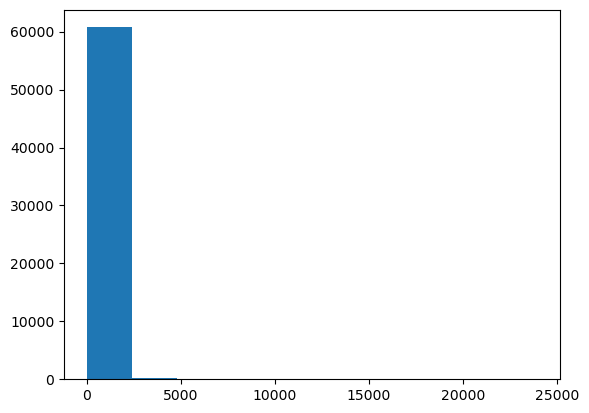

In [25]:
plt.hist(train['like_cnt'])
plt.show()

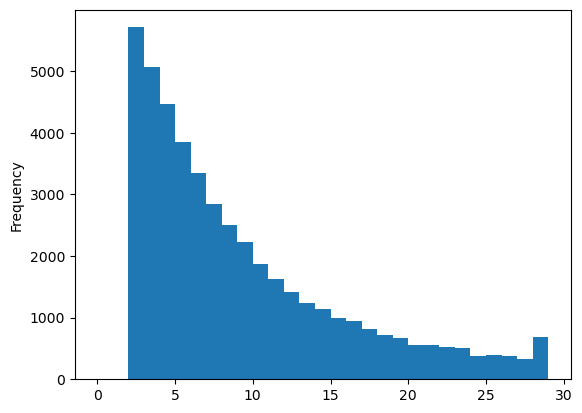

In [26]:
train['like_cnt'].plot.hist(bins=range(0, 30, 1))
plt.show()

In [27]:
# 하위 25% 미만 삭제 시 삭제되는 행 개수
tmp = train.sort_values(by=['like_cnt'],ascending=False)
tmp = tmp[tmp['like_cnt']>=5]
len(train) - len(tmp)

15242

In [28]:
# 하위 25% 미만은 의미가 없다고 본다.
train = train.sort_values(by=['like_cnt'],ascending=False)
train = train[train['like_cnt']>=5]
len(train)


45805

### 2. freq_thr

- song, tag 빈도수 기준으로 threshold(임계값) 정하기

In [29]:
# 플레이리스트 내 song id 리스트
train_song = train['songs']
# 플레이리스트 내 tag 리스트
train_tag = train['tags']
# 플레이리스트 내 song id 리스트 전체 나열
song_list = [song for plist in train_song for song in plist]
# 플레이리스트 내 tag 리스트 전체 나열
tag_list = [tag for plist in train_tag for tag in plist]

In [30]:
# 전체 나열 리스트 중 각 song의 개수
count_song = Counter(song_list)
# 전체 나열 리스트 중 각 tag의 개수
count_tag = Counter(tag_list)

In [31]:
count_song

Counter({111779: 58,
         129878: 21,
         357770: 8,
         348795: 11,
         55397: 7,
         225765: 9,
         438446: 8,
         108013: 35,
         688713: 24,
         326006: 21,
         123928: 9,
         614420: 30,
         388999: 40,
         194673: 15,
         319293: 31,
         62174: 75,
         184737: 46,
         223356: 24,
         80036: 14,
         674850: 7,
         451122: 10,
         72040: 10,
         435759: 20,
         606893: 7,
         298949: 26,
         186822: 12,
         61516: 6,
         570866: 7,
         159366: 40,
         105789: 15,
         427349: 8,
         621033: 11,
         313326: 5,
         443160: 15,
         586070: 11,
         487343: 17,
         434533: 10,
         105845: 25,
         455833: 42,
         269000: 23,
         244700: 15,
         538419: 20,
         31258: 39,
         46875: 7,
         563003: 48,
         526507: 11,
         293911: 25,
         496275: 37,
         17

In [32]:
pd.Series(count_song).describe()

count    44672.000000
mean        25.634715
std         36.736059
min          1.000000
25%          9.000000
50%         14.000000
75%         26.000000
max        856.000000
dtype: float64

In [33]:
pd.Series(count_tag).describe()

count    3399.000000
mean       55.189762
std       292.395762
min         1.000000
25%         5.000000
50%         8.000000
75%        20.000000
max      6703.000000
dtype: float64

In [34]:
# song, tag 빈도 수 하위 50% 지점을 임계값으로 설정
song_thr = 14
tag_thr = 10

In [35]:
# selected_songs = []
# song_counter = list(count_song.items())
# for k, v in song_counter:
#     if v >= song_thr:
#         selected_songs.append(k)

# len(selected_songs)

In [36]:
mfl={}  # meaningful
for key, value in count_song.items():
    if value >= song_thr:
        mfl[key]=value
song_len = len(mfl)
song_len

22589

In [37]:
# selected_tag = []
# tag_counter = list(count_tag.items())
# for k, v in tag_counter:
#     if v >= tag_thr:
#         selected_tag.append(k)

# len(selected_tag)

In [38]:
for key, value in count_tag.items():
    if value>=tag_thr:
        mfl[key]=value
tag_len=len(mfl)-song_len # 11회 이상 담긴 tag의 개수
tag_len

1518

In [39]:
mfl

{111779: 58,
 129878: 21,
 108013: 35,
 688713: 24,
 326006: 21,
 614420: 30,
 388999: 40,
 194673: 15,
 319293: 31,
 62174: 75,
 184737: 46,
 223356: 24,
 80036: 14,
 435759: 20,
 298949: 26,
 159366: 40,
 105789: 15,
 443160: 15,
 487343: 17,
 105845: 25,
 455833: 42,
 269000: 23,
 244700: 15,
 538419: 20,
 31258: 39,
 563003: 48,
 293911: 25,
 496275: 37,
 175262: 34,
 509949: 20,
 333768: 76,
 12965: 15,
 73440: 30,
 191309: 59,
 92727: 41,
 184543: 87,
 478067: 19,
 612090: 23,
 482340: 123,
 287570: 15,
 700535: 17,
 600872: 76,
 365717: 18,
 259622: 135,
 99405: 51,
 117518: 194,
 413422: 283,
 170279: 222,
 344327: 118,
 541598: 25,
 447468: 70,
 477206: 102,
 669918: 89,
 362252: 31,
 87412: 52,
 464051: 459,
 11657: 496,
 623820: 49,
 7605: 82,
 211063: 102,
 563620: 142,
 528972: 18,
 410108: 72,
 612944: 70,
 206254: 46,
 71842: 85,
 554751: 348,
 34258: 113,
 93405: 85,
 32120: 242,
 38545: 51,
 428898: 43,
 40025: 125,
 165942: 78,
 314714: 89,
 266399: 111,
 502078: 268,

In [40]:
# meaningful_feature_len = len(selected_songs) + len(selected_tag)
# meaningful_feature_len

In [41]:
mfl_col = list(mfl.keys())
len(mfl_col) # 유의미한 song과 tag의 총 개수 (song_len+tag_len)

24107

### 3. One-Hot Encoding

In [189]:
# 전체 플레이리스트를 row, 유의미한 song과 tag를 column으로 하는 zero matrix 생성
zero_matrix = np.zeros((len(train),len(mfl_col)))
zero_matrix.shape

(45805, 24107)

In [191]:
df_zero = pd.DataFrame(zero_matrix,columns=mfl_col,index=train['id'])
df_zero.head() # matrix >> dataframe 변환

,111779,129878,108013,688713,326006,614420,388999,194673,319293,62174,...,좋은,청하,줌바,굿피플,찾아오는DJ,수록곡추천,인피니트,푸른밤종현입니다,아무생각없이,오피셜차트
id,,,,,,,,,,,,,,,,,,,,,
72658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# 각 플레이리스트에 해당하는 곡, 태그 좌표에 1 부여

def create_onehot(df,column_name):
    zero_matrix=np.zeros((len(df),len(column_name)))
    zero_df=pd.DataFrame(zero_matrix,columns=column_name,index=df['id'])
    for i in range(len(df)):
        for j in df.iloc[i,0]+df.iloc[i,3] :
            if j in column_name:
                zero_df.iloc[i,column_name.index(j)]=1
    return zero_df

In [196]:
# create_onehot 함수 활용 train data >> onehot encoding
train_onehot = create_onehot(train, mfl_col)
train_onehot.shape

(45805, 24107)

In [198]:
with open('train_onehot.pkl', 'wb') as f:
    pickle.dump(train_onehot, f)

In [2]:
with open('arena_data/orig/train_onehot.pkl', 'rb') as f:
    train_onehot = pickle.load(f)

train_onehot.shape

(45805, 24107)

In [77]:
orig_test = pd.read_json('arena_data/orig/val.json' ,typ = 'frame', encoding='utf-8')
ans_test = pd.read_json('arena_data/answers/val.json' ,typ = 'frame', encoding='utf-8')

In [78]:
orig_test.info(), ans_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15262 entries, 0 to 15261
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          15262 non-null  object
 1   id            15262 non-null  int64 
 2   plylst_title  15262 non-null  object
 3   songs         15262 non-null  object
 4   like_cnt      15262 non-null  int64 
 5   updt_date     15262 non-null  object
dtypes: int64(2), object(4)
memory usage: 715.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15262 entries, 0 to 15261
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          15262 non-null  object
 1   id            15262 non-null  int64 
 2   plylst_title  15262 non-null  object
 3   songs         15262 non-null  object
 4   like_cnt      15262 non-null  int64 
 5   updt_date     15262 non-null  object
dtypes: int64(2), object(4)
memory usage: 715.5+ KB


(None, None)

In [79]:
test = ans_test.copy()
len(test)

15262

In [80]:
# 하위 25% 미만은 의미가 없다고 본다.
test = test.sort_values(by=['like_cnt'],ascending=False)
test = test[test['like_cnt']>=5]
len(test)


11475

In [3]:
# create_onehot 함수 활용 validation data >> onehot encoding
test_onehot = create_onehot(test, mfl_col)
test_onehot.shape

NameError: name 'create_onehot' is not defined

In [207]:
with open('arena_data/answers/test_onehot.pkl', 'wb') as f:
    pickle.dump(test_onehot, f)

In [4]:
with open('arena_data/answers/test_onehot.pkl', 'rb') as f:
    test_onehot = pickle.load(f)

test_onehot.shape

(11475, 24107)

---

# AutoEncoder Basic

In [5]:
import distutils.dir_util
import tensorflow as tf
from tensorflow.keras.models import save_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [218]:
# encoding_dim=64
# input_dim=len(mfl_col)
# input_pl = Input(shape=(input_dim,))
# dropout = Dropout(0.2)(input_pl)
# encoded = Dense(encoding_dim,activation='relu')(input_pl) 
# encoded = Dense(36,activation='relu')(encoded)
# decoded = Dense(input_dim,activation='sigmoid')(encoded) 
# autoencoder = Model(input_pl,decoded)
# autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 24107)]           0         
                                                                 
 dense_16 (Dense)            (None, 64)                1542912   
                                                                 
 dense_17 (Dense)            (None, 36)                2340      
                                                                 
 dense_18 (Dense)            (None, 24107)             891959    
                                                                 
Total params: 2,437,211
Trainable params: 2,437,211
Non-trainable params: 0
_________________________________________________________________


In [6]:
encoding_dim=64
input_dim=24107 #len(mfl_col)

inputs = Input(shape=(input_dim,))
encoded = Dropout(0.2)(inputs)
encoded = Dense(encoding_dim)(encoded)
encoded = BatchNormalization()(encoded)
encoded = LeakyReLU(alpha=0.01)(encoded)

decoded = Dense(input_dim,activation='sigmoid')(encoded)
autoencoder = Model(inputs, decoded, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24107)]           0         
                                                                 
 dropout (Dropout)           (None, 24107)             0         
                                                                 
 dense (Dense)               (None, 64)                1542912   
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 24107)             1566955   
                                                       

In [217]:
# encoding_dim=64
# input_dim=len(mfl_col)

# inputs = Input(shape=(input_dim,))
# encoded = Dropout(0.2)(inputs)
# encoded = Dense(encoding_dim)(encoded)
# encoded = BatchNormalization()(encoded)
# encoded = LeakyReLU(alpha=0.01)(encoded)

# latent_feature = Dense(36, activation=LeakyReLU(alpha=0.01))(encoded)

# decoded = Dense(input_dim,activation='sigmoid')(latent_feature)
# autoencoder = Model(inputs, decoded, name='autoencoder')
# autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 24107)]           0         
                                                                 
 dropout_6 (Dropout)         (None, 24107)             0         
                                                                 
 dense_13 (Dense)            (None, 64)                1542912   
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 36)                2340      
                                                       

In [7]:
learning_rate = 0.0005
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer,loss='binary_crossentropy')

In [8]:
autoencoder.fit(train_onehot,train_onehot,epochs=5,batch_size=64,validation_split=0.2, verbose=1)

Epoch 1/5
573/573 [==============================] - 114s 195ms/step - loss: 0.1411 - val_loss: 0.0250
Epoch 2/5
573/573 [==============================] - 99s 172ms/step - loss: 0.0121 - val_loss: 0.0104
Epoch 3/5
573/573 [==============================] - 104s 182ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 4/5
573/573 [==============================] - 102s 178ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 5/5
573/573 [==============================] - 106s 185ms/step - loss: 0.0067 - val_loss: 0.0066


In [9]:
autoencoder.save('results/autoencoder.h5')

In [10]:
autoencoder = tf.keras.models.load_model('results/autoencoder.h5')

In [11]:
predict_plist=autoencoder.predict(test_onehot)

359/359 [==============================] - 10s 24ms/step


In [58]:
song_len

22589

In [81]:
df_id = list(test['id'])
col= mfl_col
ori_song = col[:song_len]
ori_tag = col[song_len:]

song_predict = predict_plist[:,:song_len] # song output(추천곡)
tag_predict = predict_plist[:,song_len:] # tag output(추천태그)

In [82]:
len(df_id)

11475

In [83]:
result=[]
n=0
for i in df_id:
    dic={}
    dic['id']=i

    plist_song=song_predict[n].argsort()[-100:] # predict한 song output 중 상위 100개
    p_song=[]
    for song in plist_song:
        p_song.append(ori_song[song])
    dic['songs']=p_song

    plist_tag=tag_predict[n].argsort()[-10:] # predict한 tag output 중 상위 10개
    p_tag=[]
    for tag in plist_tag:
        p_tag.append(ori_tag[tag])
    dic['tags']=p_tag
    n+=1
    result.append(dic)

In [84]:
import os
import io
def write_json(data, fname):
    def _conv(o):
        if isinstance(o, (np.int64, np.int32)):
            return int(o)
        raise TypeError

    parent = os.path.dirname(fname)
    distutils.dir_util.mkpath(parent)
    with io.open(fname, "w", encoding="utf-8") as f:
        json_str = json.dumps(data, ensure_ascii=False, default=_conv)
        f.write(json_str)

In [85]:
write_json(result,'results/result_ae_0928.json')

In [86]:
# orig/train
# answers/val
len(result)


11475

In [87]:
len(test)

11475

In [88]:
def load_json(fname):
    with open(fname, encoding='utf-8') as f:
        json_obj = json.load(f)

    return json_obj

In [89]:
tmp = load_json('results/result_ae_0928.json')
len(tmp)

11475

In [103]:
gt_playlists = load_json('arena_data/answers/val_like_cnt_5.json')
gt_dict = {g["id"]: g for g in gt_playlists}
rec_playlists = load_json('results/result_ae_0928.json')
gt_ids = set([g["id"] for g in gt_playlists])
rec_ids = set([r["id"] for r in rec_playlists])

In [104]:
gt_ids != rec_ids

False

In [107]:
len(gt_ids), len(rec_ids)

(11475, 11475)

In [98]:
# test.to_json('arena_data/answers/val_like_cnt_5.json', orient='records')

In [ ]:
tmp = load_json('arena_data/answers/val_like_cnt_5.json')
tmp

In [ ]:
val = load_json('arena_data/answers/val.json')
val

In [116]:
ans_val = pd.read_json('arena_data/answers/val_like_cnt_5.json')
result_val = pd.read_json('results/result_ae_0928.json')

In [117]:
ans_val.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,"[노동요, 취향저격, 드라이브, Pop, 기분전환, 트렌디, 스트레스, 신나는]",74220,HOT TRENDY POP 놓쳐선 안될 POP 매주 업데이트,"[424328, 248200, 204192, 621033, 144941, 94648...",53211,2020-04-17 14:32:23.000
1,"[피아노, 수험생, 뉴에이지, 공부, 북카페]",46039,공부할때 마다 듣는 잔잔한 피아노,"[518831, 643070, 644026, 349903, 75974, 524891...",14371,2018-05-04 21:18:04.000
2,"[주말, 오후, 작업할때, 긍정적, 혼자만의시간]",98049,오늘은 집순이 음악 틀어놓고 뒹굴뒹굴 놀아요 1,"[458575, 208625, 369424, 190881, 200765, 54771...",12820,2020-03-28 15:30:36.000
3,"[운동, 기분전환, 런닝머신, 러닝]",37684,운동 미친듯이뛰고싶을때 업뎃5 29,"[609326, 153175, 547427, 198009, 649359, 57998...",12140,2019-05-29 02:37:09.000
4,"[힙합, 클럽, 흥, 밤, 댄스]",113076,온몸을 들썩거릴 빵빵한 비트,"[142983, 266059, 180669, 362347, 308598, 39636...",10127,2018-06-01 06:01:44.000


In [119]:
result_val[result_val['id']==113076]

,id,songs,tags
4,113076,"[485957, 571016, 395080, 16455, 545693, 506648...","[신나는, 여름, 랩, 스트레스, 운동, EDM, 일렉, 댄스, 힙합, 클럽]"
